# ARIMA 모형

시계열 분석을 위한 통계적 모형.

AR모형과 MA모형을 결합한 형태로 가장 일반적인 시계열 분석 방법이다.

ARIMA를 적용하기 전에 ACF, PACF플롯을 통해 적절한 파라미터를 찾아야 한다.

## #01. 준비작업

### [1] 패키지 가져오기

In [1]:
import warnings
warnings.filterwarnings(action='ignore')

from hossam.util import *
from hossam.plot import *
from hossam.timeserise import *

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from matplotlib import dates

### [2] 데이터 가져오기

In [2]:
origin = my_read_excel("https://data.hossam.kr/tsdata/air_passengers.xlsx", index_col="Month", info=False)

## #02. ACF, PACF 검정

정상 시계열 데이터의 경우, ACF는 상대적으로 빠르게 0(상관관계 0)에 접근한다.

비정상 시계열 데이터의 경우, ACF는 천천히 감소하며 종종 큰 양의 값을 갖는다.

| 구분 | $AR(p)$ 모델 적합 | $MA(q)$ 모델 적합 |
|---|---|---|
| ACF plot | 천천히 감소 | 첫 값으로부터 $q$개 뒤에 끊긴다. |
| PACF plot | 첫 값으로부터 $p$개 뒤에 끊긴다. | 천천히 감소 |

### [1] ACF 플롯

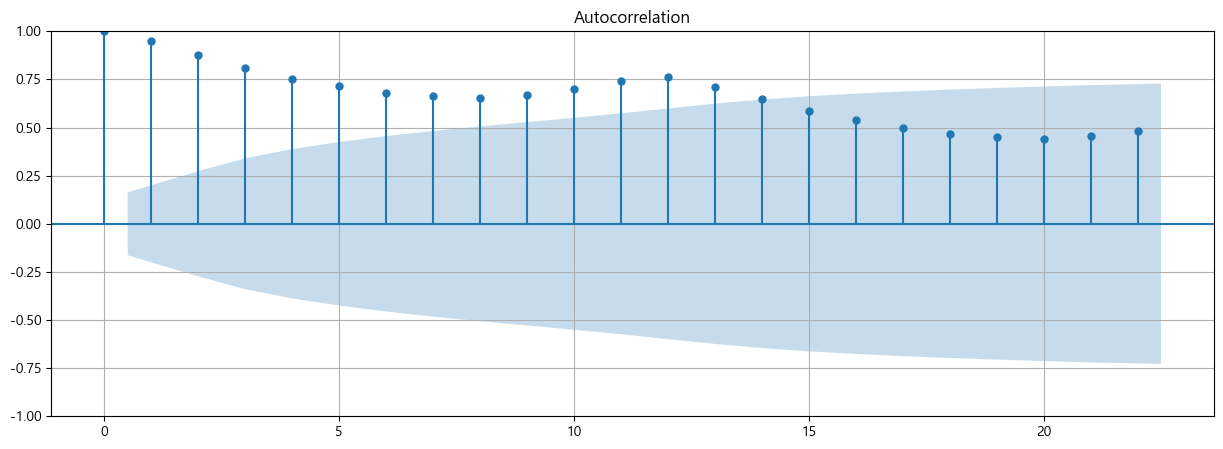

In [3]:
fig = plt.figure(figsize=(15, 5), dpi=100)
ax = fig.gca()

plot_acf(origin['Passengers'], ax=ax)

ax.grid()
plt.show()
plt.close()

### [2] PACF 검정

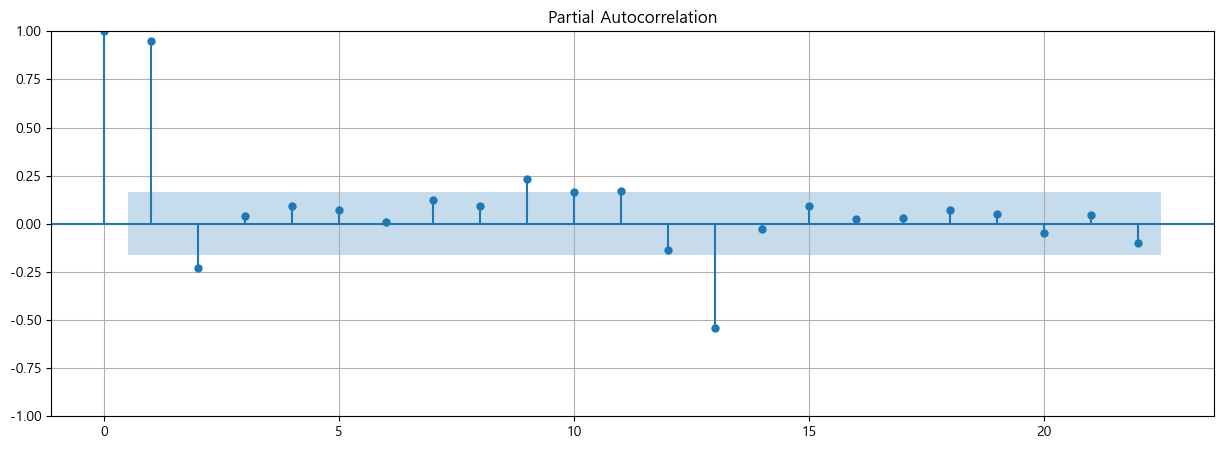

In [4]:
fig = plt.figure(figsize=(15, 5), dpi=100)
ax = fig.gca()

plot_pacf(origin['Passengers'], ax=ax)

ax.grid()
plt.show()
plt.close()

### [3] 결과 판정

| 구분 | ACF plot | PACF plot |
|---|---|---|
| 감소 | 상대적으로 완만 | 상대적으로 급격 |
| 파란박스 진입 지점 | $p=1$ | $q=1$ |

이 결과를 고려하여 완만함을 보이는 ACF 플롯을 채택 

$AR(1)$ 모델로 결정

현재 차분을 수행하지 않았으므로 $d$값은 `0`인 상태임

## #03. ARIMA 분석 수행

시계열 데이터를 ARIMA 모델에 맞추려고 할 때 첫 번째 목표는 측정항목을 최적화하는 $ARIMA(p,d,q)(P,D,Q,s)$ 값을 찾는 것

> `s` 계절주기

### [1] 분석 모형 만들기

In [5]:
# 기본 코드
#model = ARIMA(origin['Passengers'], order=(1, 0, 0))

# 계절성 고려
# 월 단위 데이터이므로 1년 주기로 보고 주기를 12로 설정(분석가가 직접 판단)
model = ARIMA(origin['Passengers'], seasonal_order=(1, 0, 0, 12))

fit = model.fit()
print(fit.summary())

                               SARIMAX Results                                
Dep. Variable:             Passengers   No. Observations:                  144
Model:             ARIMA(1, 0, 0, 12)   Log Likelihood                -739.888
Date:                Tue, 12 Mar 2024   AIC                           1485.776
Time:                        10:54:03   BIC                           1494.686
Sample:                    01-01-1949   HQIC                          1489.396
                         - 12-01-1960                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        298.8789     46.924      6.369      0.000     206.910     390.847
ar.S.L12       0.9773      0.033     29.584      0.000       0.913       1.042
sigma2      1312.3966    296.814      4.422      0.0

### [2] 학습 결과에 대한 예측값 생성

#### (1) 훈련데이터에 대한 예측값

In [6]:
start_index = 0
end_index = len(origin['Passengers'])
pd = fit.predict(start=start_index, end=end_index)
pd

1949-01-01    298.878858
1949-02-01    298.878858
1949-03-01    298.878858
1949-04-01    298.878858
1949-05-01    298.878858
                 ...    
1960-09-01    459.278504
1960-10-01    404.548321
1960-11-01    360.568709
1960-12-01    402.593671
1961-01-01    414.321568
Freq: MS, Name: predicted_mean, Length: 145, dtype: float64

#### (2) 이후 1년간의 추가 적인 예측값 생성

In [7]:
fc = fit.forecast(12)
fc

1961-01-01    414.321568
1961-02-01    388.911126
1961-03-01    416.276217
1961-04-01    457.323855
1961-05-01    468.074426
1961-06-01    529.645882
1961-07-01    614.673131
1961-08-01    599.035936
1961-09-01    503.258116
1961-10-01    457.323855
1961-11-01    387.933801
1961-12-01    428.981438
Freq: MS, Name: predicted_mean, dtype: float64

#### (3) 관측치와 예측치의 비교 결과 시각화

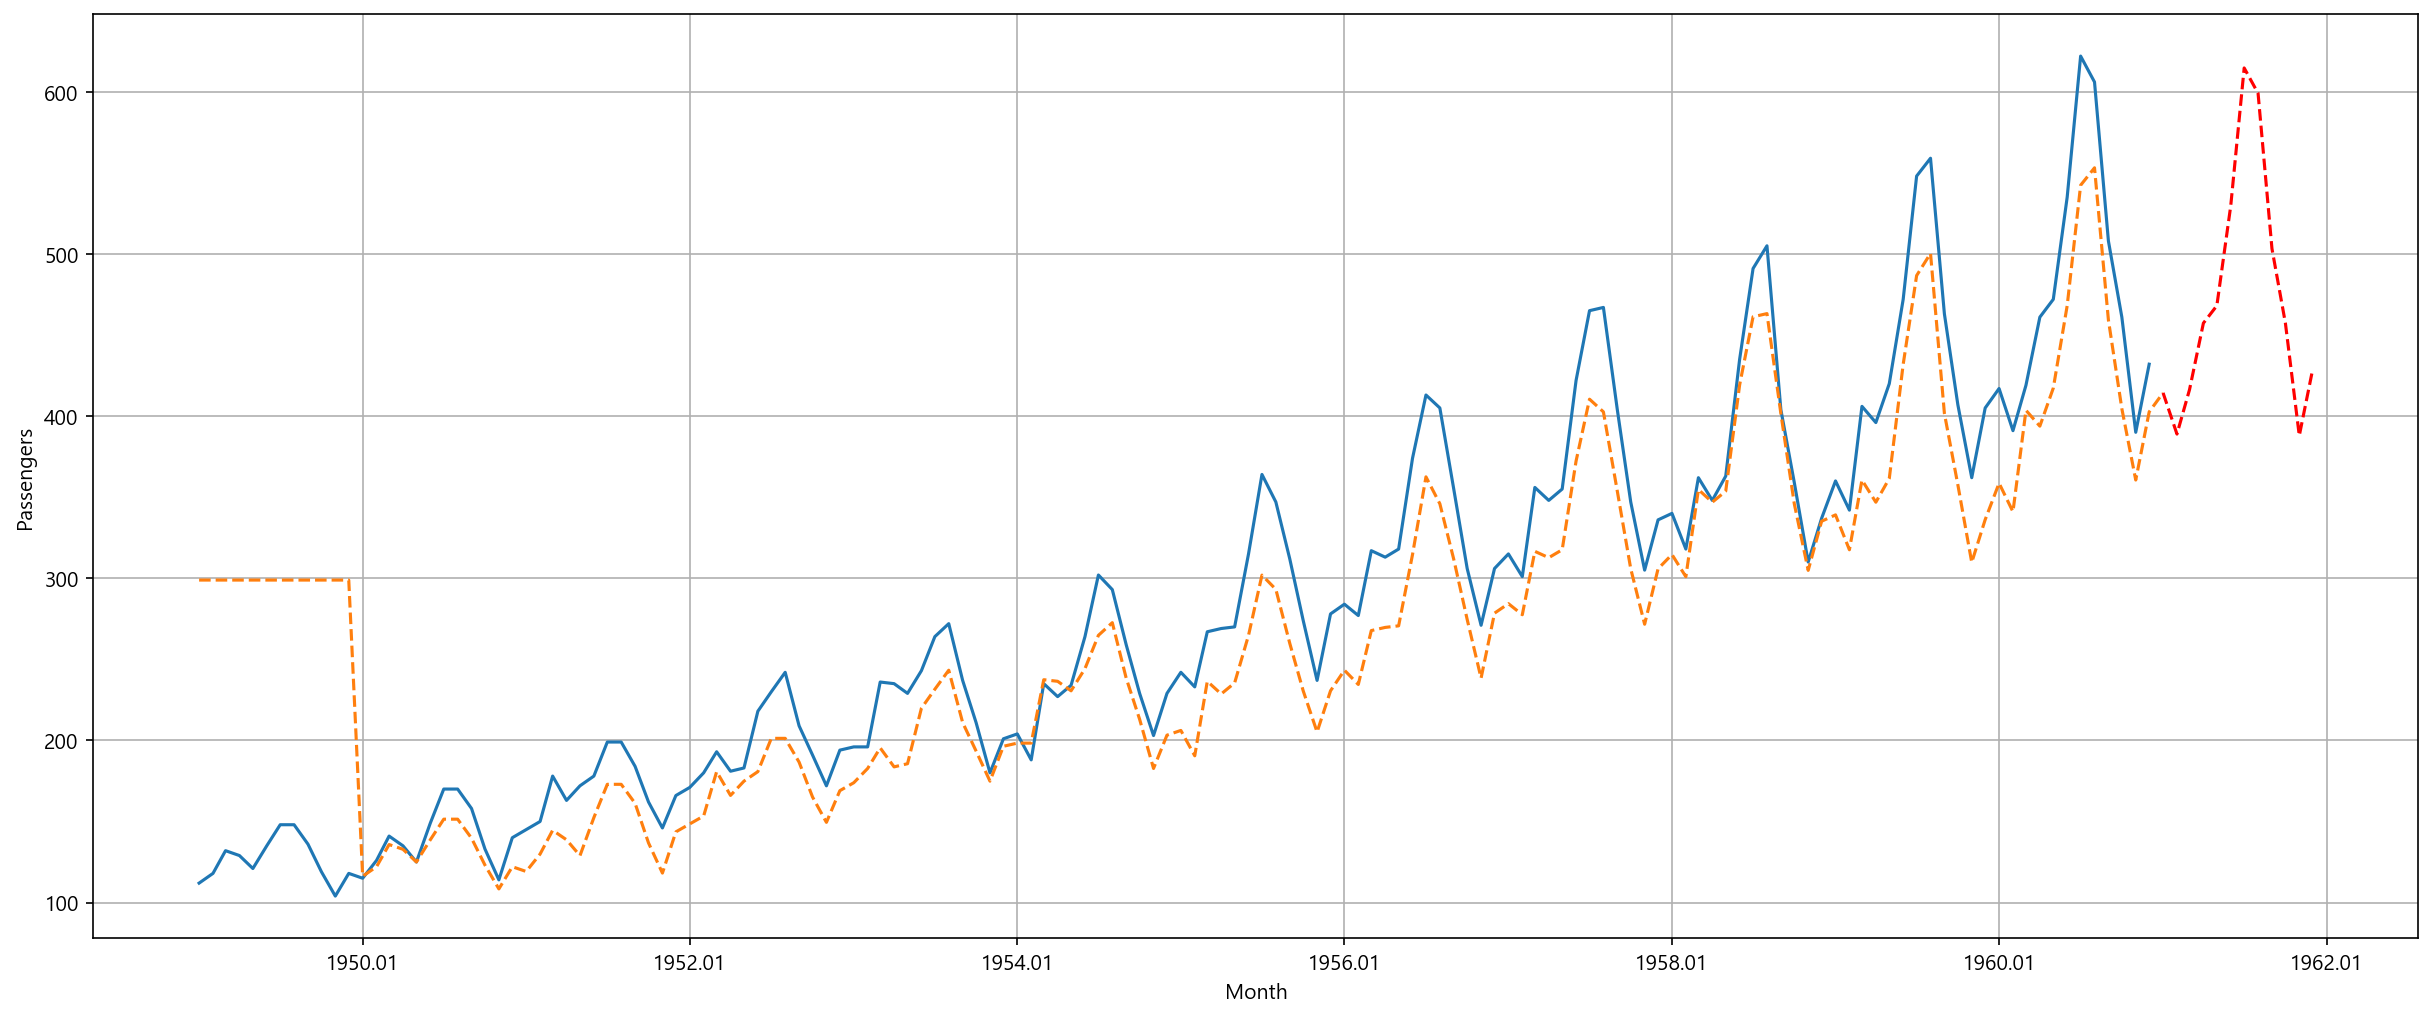

In [8]:
fig = plt.figure(figsize=(20,8), dpi=150)
ax = fig.gca()

# 원본
sb.lineplot(x=origin.index, y=origin['Passengers'], ax=ax)

# 원본을 토대로 학습하여 예측한 값
sb.lineplot(x=pd.index, y=pd, linestyle='--', ax=ax)

# 이후 10단계를 예측한 값
sb.lineplot(x=fc.index, y=fc, linestyle='--', color='red', ax=ax)

ax.set_xlabel('Month')
ax.set_ylabel('Passengers')
ax.grid()

# 그래프의 축이 날짜 형식일 경우 출력할 날짜 포멧 지정
monthyearFmt = dates.DateFormatter("%Y.%m")
ax.xaxis.set_major_formatter(monthyearFmt)

plt.show()
plt.close()

> 결정된 모델로 시계열 분석을 수행한 결과의 `p-value`가 0.05보다 작으면 귀무가설을 기각하고 대립가설 채택. 즉 예제 데이터는 정상성 데이터.
> 
> 만약 귀무가설이 채택되어 정상성이 아니라고 판단될 경우 차분을 1회 수행하고 다시 ADF 검정을 수행한 후 ARIMA 모델을 다시 찾는다.
> 
> 대립가설이 채택될 때 까지 이 과정을 반복함
> 
> 반복횟수가 $d$ 값이 됨 